# **seismo-at-school: RaspberryShake Switzerland**

Die Webanwendung ermöglicht Dir, auf die Daten aller RaspberryShake Schulsensoren in der Schweiz zuzugreifen und Seismogramme darstellen. Sie wurde im Rahmen des *seismo-at-school* Projektes am Schweizerischen Erdbebendienst ([SED](http://seismo.ethz.ch/de/home/)) an der ETH Zürich in Zusammenarbeit mit der Universität Lausanne ([UNIL](https://www.unil.ch/index.html)) und dem Centre Pédagogique Prévention Séisme ([CPPS](https://www.cpps-vs.ch/home)) in Sion entwickelt.

Um den nachfolgenden Code auszuführen, gehe zunächst auf die Menuleiste oben und klicke unter Menupunkt **Run** auf **Run All Cells**. Du solltest nach etwa einer Minute unterhalb der Code-Zellen Ergebnisse sehen. Du kannst Parameter, wie zum Beispiel das Erdbeben oder den RaspberryShake selbst wählen und den Code erneut ausführen, um die Seismogramme zu sehen. **Klicke dazu auf die jeweilige Zelle und dann auf den Pfeil im Menu oben.** Code-Zellen können auch einzeln ausgeführt werden. Falls Du schon etwas Python programmieren kannst, kannst Du den Code auch selbst verändern oder erweitern.


Lade zunächst ein paar Bibliotheken und Variablen, die der Code benötigt, indem Du den Code in der nächsten Zelle ausführst.

In [10]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

# Install/Load libraries:
import warnings
warnings.filterwarnings("ignore")
try:
    import obspy
except:
    !pip install obspy | grep -v 'already satisfied'

try:
    import cartopy
except:
    !pip install cartopy | grep -v 'already satisfied'

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace, Stats
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import widgets, interact, Dropdown, Select


# Katalog-Suche;
options_year=[("2023",0),("2024",1),("2025",2)]
function_year = widgets. Dropdown (
  options=options_year,
  value=1,
  description='Jahr: ')
function_year
eq_search1 = {'local':['2.5','3.5','4.0'],'global':['5.0','5.5','6.0','6.5','7.0']}


# RaspberryShake:
rs_sta_list =[
["GBIEL","S8C09", "CHASS","GBIEL, Gymnasium Biel-Seeland Biel"],
["GLSTL","RDFB5", "MUTEZ","GLSTL, Gymnasium Liestal"],
["GOBZL","R19BB", "BALST","GOBZL, Gymnasium Oberaargau"],
["GUSTZ","R4335", "ZUR","GUSTZ, Gymnasium Unterstrass"],
["KSCHR","RB22F", "PLONS","KSCHR, Bündner KS Chur"],
["KSENZ","RD3C4","","KSENZ, KS Enge Zürich"],
["KSHOZ","RE5E7", "ZUR","KSHOZ, KS Hottingen Zürich"],
["KSKNZ","RC23B", "ZUR","KSKNZ, KS Küsnacht"],
["KSOBW","RDFB5","","KSOBW, Gymnasium Oberwil"],
["KSROM","R58D2", "WALHA","KSROM, KS Romanshorn"],
["KSRYC","RF726", "WILA","KSRYC, KS Rychenberg Winterthur"],
["KSSO","RFE6B", "MOUTI","KSSO, KS Solothurn"],
["KSURI","R8F49", "MUO","KSURI, KS Uri"],
["KSZOW","RF726", "WILA","KSZOW, KS Zürcher Oberland, Wetzikon"],
["KSZUG","R3BE0", "ZUR", "KSZUG, KS Zug"],
["MNGRZ","R7DBB", "ZUR","MNGRZ, MNG Rämibühl"],
["COAVI","RA652", "VANNI", "COAVI, CO d'Anniviers"],
["COAYT","RB15C", "SENIN", "COAYT, CO Ayent"],
["CLREN","R3BDC", "", "CLREN, OFFLINE Collège du Léman"],
["COHEU","RB289", "DIX", "COHEU, CO Hérens"],
["COLEY","RA7C7", "GRYON", "COLEY, CO Leytron"],
["COLSL","RE4EF", "VANNI", "COLSL, CO des Liddes"],
["COORS","S3900", "MFERR", "COORS, CO Orsières"],
["COPCM","RA83F", "ILLEZ", "COPCM, CO des Perraires"],
["COSAV","R2D50", "SENIN", "COSAV, CO Savièse"],
["COSTG","R7694", "SENIN", "COSTG, CO St-Guérin"],
["CPPSS","R05D6", "SENIN", "CPPSS, partner institution (SION CPPS HES-SO)"],
["EAMCX","S7A06", "SALAN", "EAMCX, Ecole de l'Arpille"],
["EDILA","RC676", "GOURZ", "EDILA, partner institution (EDI LAUSANNE)"],
["EPSBE","R65E9", "VINZL", "EPSBE, EPS de Begnins – L'Esplanade"],
["EPSEC","R8710", "GOURZ", "EPSEC, EPS Ecublens"],
["EPSGD","R3B57", "CHAMB", "EPSGD, EPS Grandson"],
["EPSLB","R0CD2", "", "EPSLB, OFFLINE EPS Bergières"],
["EPSLE","R5BF0", "GOURZ", "EPSLE, Collège/EPS de l'Elysée"],
["EPSVP","RF727", "GOURZ", "EPSVP, EPSCL Collège du Verney"],
["ESLAS","R8E4D", "LASAR", "ESLAS, ES de La Sarraz et environs"],
["ESNYM","R5D35", "", "ESNYM, OFFLINE ES Nyon-Marens"],
["ESPEC","R46E5", "", "ESPEC, OFFLINE ES du Pays-d'Enhaut"],
["ESTSE","R52F7", "", "ESTSE, OFFLINE ES des Trois-Sapins"],
["ESSTI","R1F5E", "CHASS", "ESSTI, ES St-Imier"]
]

# Filter Parameter:
filt_type = ["teleseismic", "regional", "local", "hyperlocal"]
filt_dist = [9000, 6000, 100, 0]
filt_freqmin = [0.1, 0.7, 3.0, 3.0]
filt_freqmax = [0.8, 2.0, 8.0, 20.0]
filt_timewindow_start = [(-15 * 60), (-15 * 60), (-0.5 * 60), 0, 0]
filt_timewindow_end = [(60 * 60), (60 * 60), (5 * 60), (2 * 60), (1.5 * 60)]

# Wellengeschwindigkeiten:
vp = 5.8 # km/s P-Welle
vs = 3.4 # km/s S-Welle

# Model zur Vorhersage der theoretische Ankunftszeiten von verschiendenen seismischen Wellenphase:
model = TauPyModel(model="iasp91")

# SED Breitband-Stationen:
inv_ch = Client("ETH").get_stations(network="CH", station="*", location="--", channel="HH*", level="RESP")
inv_ch = inv_ch.select(channel="*Z", station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

# Seismo-at-school RaspberryShake Stationen:
inv_s = Client("ETH").get_stations(network="S", station="*",location="--", channel="EH*", level="RESP")
inv_s = inv_s.select(channel="*Z", station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

#print("Ich habe " + str(len(inv_ch[0])) + " SED Breitband-Stationen und " + str(len(inv_s[0])) + " Seismo-at-school RaspberryShake Stationen in der Schweiz gefunden.")

**SCHRITT 1: Wähle ein Erdbeben aus**

Je nach Entfernung zwischen dem Erdbeben und der Erdbebenstation (oder RaspberryShake) unterscheidet man zwischen lokalen und globalen Erdbeben. Lokale Erdbeben sind bis zu etwa 200 km entfernt, globale Erdbeben haben grössere Entfernungen.  Erdbeben in der Schweiz und im grenznahen Ausland sind aus Sicht des schweizerischen Netzwerkes lokal, Erdbeben, wie beispielsweise in Japan, zählen zu den globalen Erdbeben.

Wähle zunächst die Parameter für Deine Erdbebensuche aus.

In [2]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

display(function_year)

eq_typeW = Select(options = eq_search1.keys())
eq_minmagW = Select(options = eq_search1.get('local'))

def update_eq_minmagW_options(*args): # *args represent zero (case here) or more arguments.
    eq_minmagW.options = eq_search1[eq_typeW.value]

eq_typeW.observe(update_eq_minmagW_options) # options based onvalue.

@interact(Erdbeben = eq_typeW, minMag = eq_minmagW)
def cat_search(Erdbeben, minMag):
  print("Du hast folgende Parameter gewählt: " +Erdbeben+", minimale Magnitude:" +str(minMag))

Dropdown(description='Jahr: ', index=1, options=(('2023', 0), ('2024', 1), ('2025', 2)), value=1)

interactive(children=(Select(description='Erdbeben', options=('local', 'global'), value='local'), Select(descr…

In dem Dropdown-Menu findest Du alle Erdbeben, die für Deine Suchparameter gefunden wurden. Suche ein Erdbeben aus, das Dich interessiert.

In [45]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

year = int(options_year[function_year.value][0])
eq_type = eq_typeW.value
minmag = float(eq_minmagW.value)
maxmag = 10.
print(year)

# local configuration
if eq_type == "local":
  server = "ETH"
# global configuration
else:
  server = "IRIS"

# Catalog search:
try:
  cat = Client(server).get_events(minmag=minmag, maxmag=maxmag, starttime=obspy.UTCDateTime(str(year) + "-01-01T00:00"), endtime=obspy.UTCDateTime(str(year+1) + "-01-01T00:00"))
  print("Ich habe " + str(len(cat)) +" Erdbeben mit einer Magnitude zwischen " +str(minmag)+ " bis " +str(maxmag)+ " im Jahr " +str(year)+ " gefunden.")
  #print(cat.__str__(print_all=True))
except:
  print("Ich habe keine Erdbeben für Deine Suchanfrage gefunden. ändere Deine Parameter und versuche es noch einmal.")

options_eqs = []
for idx, sta in enumerate(cat):
  options_eqs.append(("Magnitude "+str(np.around(cat[idx].magnitudes[0].mag,decimals=1))+"    "+str(cat[idx].origins[0].time)+"    "+str(cat[idx].event_descriptions[0].text),idx))


function_eqs = widgets.Dropdown(
  options=options_eqs,
  value=0,
  description='Erdbeben: ')
function_eqs
display(function_eqs)

2024
Ich habe 19 Erdbeben mit einer Magnitude zwischen 2.5 bis 10.0 im Jahr 2024 gefunden.


Dropdown(description='Erdbeben: ', options=(('Magnitude 2.8    2024-05-06T11:39:15.866333Z    Fribourg FR', 0)…

Führe den nächsten Code aus, um das Erdbeben auf einer Karte darzustellen.

Mulhouse F
Das Erdbeben ereignete sich an Länge = 47.767 Grad und Breite = 7.407 Grad. Es hatte eine Tiefe von 19 km und eine Magnitude von 2.7.


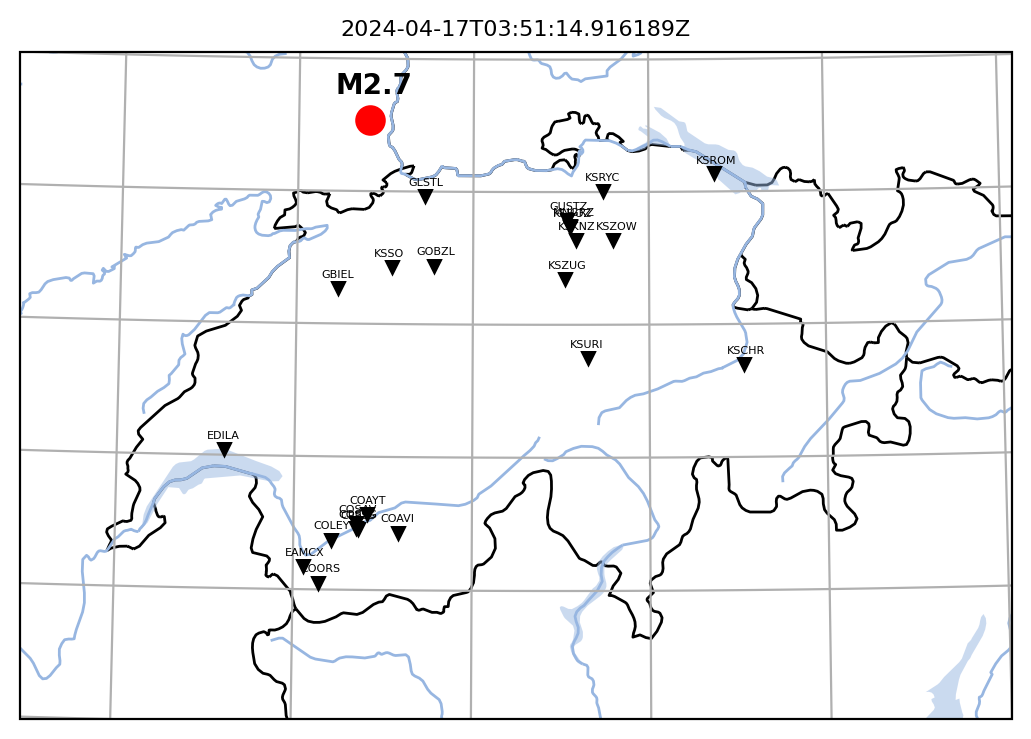

Dropdown(description='Raspberry: ', index=11, options=(('GBIEL, Gymnasium Biel-Seeland Biel', 0), ('GLSTL, Gym…

In [46]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

origin_time = cat[function_eqs.value].origins[0].time

# Catalog search
try:
  eq = Client(server).get_events(minmag=minmag, starttime=obspy.UTCDateTime(origin_time-5), endtime=obspy.UTCDateTime(origin_time+5))
  eq_lat = eq[0].origins[0].latitude
  eq_lon = eq[0].origins[0].longitude
  eq_depth = eq[0].origins[0].depth/1000
  eq_mag = eq[0].magnitudes[0].mag
  print(eq[0].event_descriptions[0].text)
  print("Das Erdbeben ereignete sich an Länge = " + str(np.around(eq_lat,decimals=3)) +
        " Grad und Breite = " + str(np.around(eq_lon,decimals=3)) + " Grad. Es hatte eine Tiefe von " + str(round(eq_depth)) +
        " km und eine Magnitude von " +str(np.around(eq_mag,decimals=1)) +".")
except:
  print("Ich habe kein Beben finden können. Probiere es noch einmal mit einer anderen Herdzeit.")


# Plot map:
# Set up a figure
fig = plt.figure(dpi=200)
if eq_type=="local" or eq_type=="hyperlocal":
    # Set up a custom projection
    projection = ccrs.AlbersEqualArea(
        central_longitude=8.5,
        central_latitude=46.5,
    )
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent((5.5, 11., 45.5, 48))
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
else:
    #Set up a custom projection
    projection = ccrs.PlateCarree()
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent((-180, 180., -90, 90))
    ax.stock_img()

# Draw standard features
ax.gridlines()
ax.coastlines()
ax.set_title(origin_time,fontsize=8)

for inv in inv_s[0]:
    plt.plot(inv.longitude,inv.latitude,'kv',markersize=4,transform=ccrs.Geodetic())
    if eq_type=="local" or eq_type=="hyperlocal":
        plt.text(inv.longitude-0.1,inv.latitude+0.04,inv.code,size=4,transform=ccrs.Geodetic())
plt.plot(eq_lon,eq_lat,'ro',markersize=10, transform=ccrs.Geodetic())
plt.text(eq_lon-0.2,eq_lat+0.1,'M'+str(np.around(eq_mag,decimals=1)), fontweight="bold", transform=ccrs.Geodetic())
plt.show()

# All seismo-at-school RaspberryShake in Switzerland:
#print(inv_s[0])

options_rs = []
for idx, sta in enumerate(rs_sta_list):
  options_rs.append((rs_sta_list[idx][3],idx))

function = widgets. Dropdown (
options=options_rs,
value=11,
description='Raspberry: ')
function
display(function)

**SCHRITT 2: Wähle einen RaspberryShake aus**

Wähle nun aus aus dem Dropdown Menu einen RaspberryShake aus, der Dich interessiert. Führe dann den nachfolgenden Code aus, um das Seismogramm für diesen RaspberryShake zu laden und darzustellen. Falls Du keine Einsätze erkennen kannst, sind die Erschütterungen an der Station vermutlich zu gering.Versuche es noch einmal mit einem stärkeren oder näheren Erdbeben.

2024-04-17T03:51:14.916189Z
KSKNZ ist 101.6 km von dem Erdbeben entfernt.
Die P-Wellen (roter Strich) erreichen die Station nach 17.8 Sekunden, die S-Wellen (blauer Strich) nach 30.7 Sekunden.
Die nächste Breitband-Station ist CH.ZUR. Sie ist 5.7 km von S.KSKNZ entfernt.


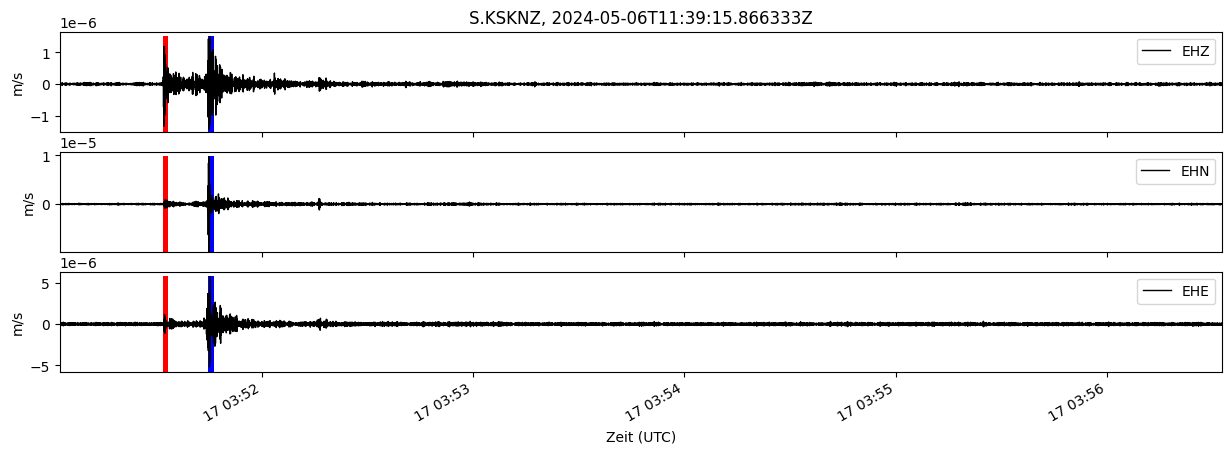

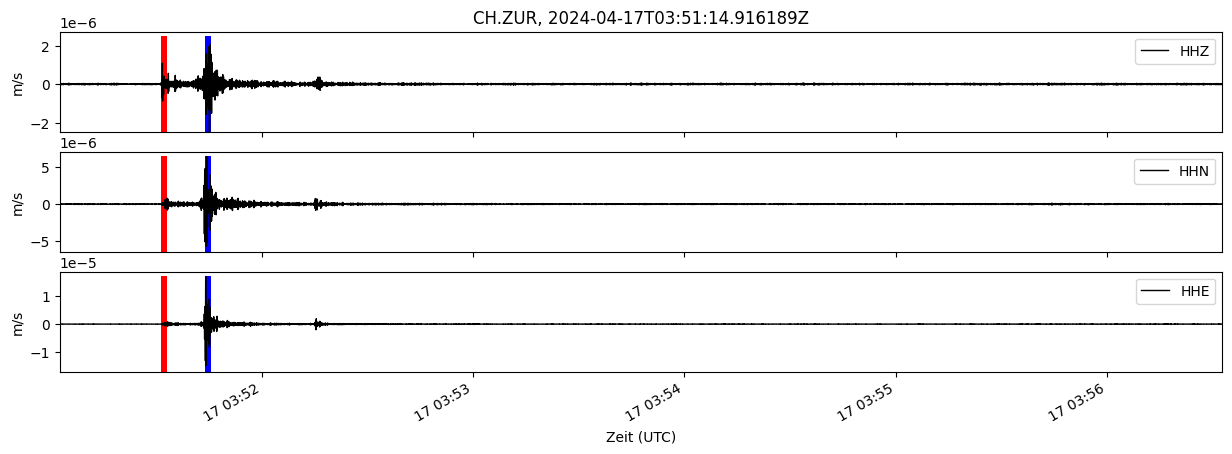

In [49]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

rs_station = rs_sta_list[function.value]
print(origin_time)
try:
  try:
    inv_rs = Client("ETH").get_stations(network="S", station=rs_station[0],
                                        location="--", channel="EH*", level="RESP",
                                        starttime=origin_time, endtime=origin_time+24*60*60)
  except:
    inv_rs= Client("RASPISHAKE").get_stations(network="AM", station=rs_station[1],
                                        location="00", channel="EH*", level="RESP",
                                              starttime=origin_time, endtime=origin_time+24*60*60)
  sta_lat = inv_rs[0][0].latitude
  sta_lon = inv_rs[0][0].longitude
  epi_dist = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)[0]/1000
  if epi_dist <=110:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["p","s"])
    p_arr = phase_arrivals[0].time
    s_arr = phase_arrivals[1].time
  elif not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["P"]) == []:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["P"])
    p_arr = phase_arrivals[0].time
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["S"])
    s_arr = phase_arrivals[0].time

  else:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111)
    p_arr = phase_arrivals[0].time
    s_arr = []


  if epi_dist >= filt_dist[0]:
    idx = 0
  elif epi_dist >= filt_dist[1]:
    idx = 1
  elif epi_dist >= filt_dist[2]:
    idx = 2
  elif epi_dist >= filt_dist[3]:
    idx = 3

  eq_type = filt_type[idx]
  freqmin = filt_freqmin[idx]
  freqmax = filt_freqmax[idx]
  timewindow_start = origin_time + filt_timewindow_start[idx]
  timewindow_end = origin_time + filt_timewindow_end[idx]
  if idx < 3:
    timewindow_start +=  p_arr
    timewindow_end +=  p_arr
  print(rs_station[0] + " ist " + str(np.around(epi_dist,decimals=1)) + " km von dem Erdbeben entfernt.")

  try:
    stream = Client("ETH").get_waveforms(network="S", station=rs_station[0],
                                         location="--", channel="EH*", starttime=timewindow_start - 60,
                                         endtime=timewindow_end + 60, attach_response=True)
  except:
    stream = Client("RASPISHAKE").get_waveforms(network="AM", station=rs_station[1],
                                                location="00", channel="EH*", starttime=timewindow_start - 60,
                                                endtime=timewindow_end + 60, attach_response=True)
  stream.merge(method=0, fill_value='interpolate')
  stream.detrend()
  stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
  stream.remove_response(output='VEL')
  stream.trim(starttime = timewindow_start, endtime = timewindow_end)

  fig = plt.figure()
  for idx, trace in enumerate(stream):
    if trace.stats.channel == "EHZ":
      ax = fig.add_subplot(len(stream),1,1)
      plt.title("S." + rs_station[0] + ", " + str(cat[0].origins[0].time))
    elif trace.stats.channel == "EHN":
      ax = fig.add_subplot(len(stream),1,2)
    else:
      ax = fig.add_subplot(len(stream),1,3)
    ax.xaxis_date()
    ax.plot(trace.times("matplotlib"), trace.data, "k-", linewidth = 1, label = trace.stats.channel)
    plt.bar(origin_time + p_arr, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
            width = (timewindow_end-timewindow_start)/200, align = "center", color = "r")
    if not s_arr == []:
      plt.bar(origin_time + s_arr, height = 2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
              width = (timewindow_end-timewindow_start)/200, align = "center", color = "b")
    plt.xlim(timewindow_start, timewindow_end)
    plt.xlabel('Zeit (UTC)')
    plt.ylabel('m/s')
    plt.legend()
    fig.autofmt_xdate()

  fig.set_figheight(5)
  fig.set_figwidth(15)

  print("Die P-Wellen (roter Strich) erreichen die Station nach " + str(np.around(p_arr,decimals=1)) +
        " Sekunden, die S-Wellen (blauer Strich) nach "+ str(np.around(s_arr,decimals=1)) + " Sekunden.")

  #print("Die Daten wurden von " +str(freqmin) + " Hertz (Hz) bis " +str(freqmax) + " Hertz (Hz) gefiltert.")

except:
  print(" ")
  print("Ich habe keine Daten für " + rs_station[0] + " gefunden.")



# Broadband Station:
# Find closest CH broadband station:
ch_dist = []
if rs_station[2]=="":
  for idx,sta in enumerate(inv_ch[0]):
    sta_ch_lat = sta.latitude
    sta_ch_lon = sta.longitude
    ch_dist.append(gps2dist_azimuth(sta_ch_lat, sta_ch_lon, sta_lat, sta_lon)[0]/1000)
  nearest_sta = inv_ch[0][np.argmin(ch_dist)].code
  sta_ch_lat = inv_ch[0][np.argmin(ch_dist)].latitude
  sta_ch_lon = inv_ch[0][np.argmin(ch_dist)].longitude
else:
   nearest_sta = rs_station[2]
   inv = Client("ETH").get_stations(network="CH", station=rs_station[2],
                                        location="--", channel="HH*", level="RESP", starttime=origin_time, endtime=origin_time+24*60*60)
   sta_ch_lat = inv[0][0].latitude
   sta_ch_lon = inv[0][0].longitude
   ch_dist.append(gps2dist_azimuth(sta_ch_lat, sta_ch_lon, sta_lat, sta_lon)[0]/1000)
epi_dist_ch = (gps2dist_azimuth(eq_lat, eq_lon, sta_ch_lat, sta_ch_lon)[0]/1000)


# Theoretical phase arrivals:
if epi_dist_ch <=110:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["p","s"])
  p_arr = phase_arrivals[0].time
  s_arr = phase_arrivals[1].time
elif not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist_ch/111.111,phase_list=["P"]) == []:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["P"])
  p_arr = phase_arrivals[0].time
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["S"])
  s_arr = phase_arrivals[0].time

else:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111)
  p_arr = phase_arrivals[0].time
  s_arr = []

try:
  stream = Client("ETH").get_waveforms(network="CH", station=nearest_sta, location="--", channel="HH*",
                                       starttime = timewindow_start - 60, endtime = timewindow_end + 60, attach_response = True)
  stream.merge(method=0, fill_value='interpolate')
  stream.detrend()
  stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
  stream.remove_response(output='VEL', taper = True)
  stream.trim(starttime = timewindow_start, endtime = timewindow_end)

  fig = plt.figure()
  for idx, trace in enumerate(stream):
    if trace.stats.channel == "HHZ":
      ax = fig.add_subplot(len(stream),1,1)
      plt.title("CH." + nearest_sta+ ", " + str(origin_time))
    elif trace.stats.channel == "HHN":
      ax = fig.add_subplot(len(stream),1,2)
    else:
      ax = fig.add_subplot(len(stream),1,3)
    ax.xaxis_date()
    ax.plot(trace.times("matplotlib"), trace.data, "k-", linewidth = 1, label = trace.stats.channel)
    plt.bar(origin_time + p_arr, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
            width = (timewindow_end-timewindow_start)/200, align = "center", color = "r")
    if not s_arr == []:
      plt.bar(origin_time + s_arr, height = 2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
              width = (timewindow_end-timewindow_start)/200, align = "center", color = "b")
    plt.xlim(timewindow_start, timewindow_end)
    plt.xlabel('Zeit (UTC)')
    plt.ylabel('m/s')
    plt.legend()
    fig.autofmt_xdate()
    fig.set_figheight(5)
    fig.set_figwidth(15)
  print("Die nächste Breitband-Station ist CH." + nearest_sta + ". Sie ist " +str(np.around(min(ch_dist),decimals=1)) + " km von S." + rs_station[0] + " entfernt.")
  #print("Diese Seismogramme hat die nächstgelegene Breitbandstation im SED Netzwerk aufgezeichnet.")


except:
  print("Ich haben leider keine Daten gefunden. Aendere die Parameter und versuche es noch einmal.")

**SCHRITT 3: Seismogramme von allen seismo-at-school RaspberryShake**

Führe den Code in der nächsten Zelle aus, um die Seismogramme von allen seismo-at-school RaspberryShake in der Schweiz zu sehen.

Ich habe keine Seismogramme für GBIEL gefunden.


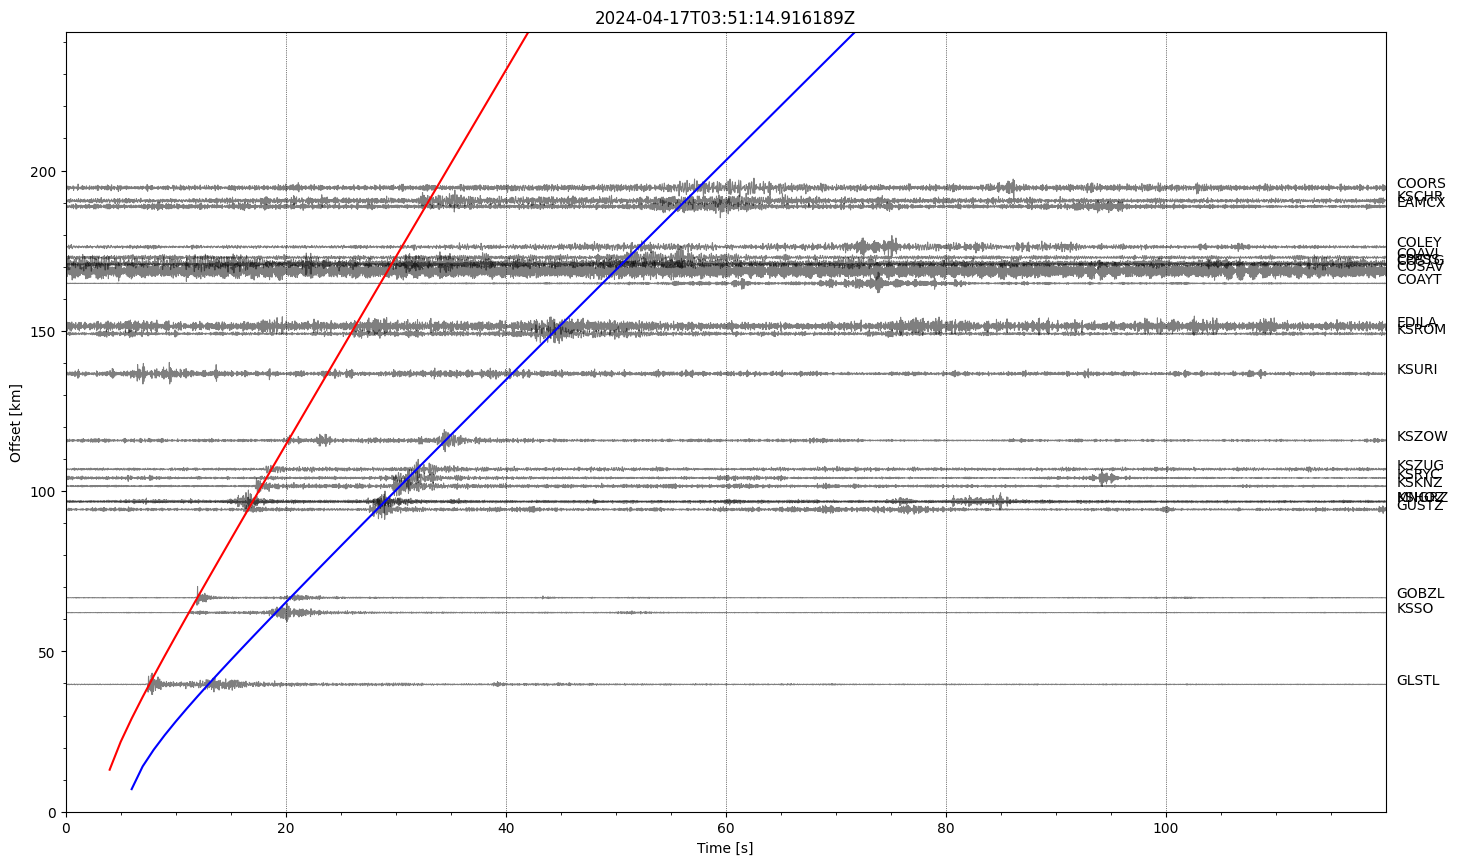

In [48]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:


try:
  for network in ["S"]:
    if network == "CH":
      inventory = inv_ch
    else:
      inventory = inv_s
    stream = Stream()
    distance = []
    name = []
    for idx, inv in enumerate(inventory[0]):
      try:
        station = inv.code
        trace = Client("ETH").get_waveforms(network=network, station=station, location="--",
                                            channel="*Z", starttime=origin_time -60, endtime=timewindow_end +60, attach_response=True)
        trace.merge()
        distance.append(gps2dist_azimuth(inv.latitude, inv.longitude, eq_lat, eq_lon)[0])
        name.append(station)
        stream += trace
      except:
        print("Ich habe keine Seismogramme für " +str(station) + " gefunden.")

    stream.remove_response(output='VEL')
    stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    stream.trim(starttime = origin_time, endtime = timewindow_end)

    for idx, trace in enumerate(stream):
      trace.stats.distance = distance[idx]
      trace.stats.station = name[idx]

    fig = plt.figure()
    stream.plot(type='section', orientation='horizontal', right_vertical_labels=True,
                linewidth=.75, grid_linewidth=.5, scale=0.75, show=True, fig=fig,
                localization_dict={'Time [s]': 'Zeit [s]', 'Offset [km]': 'Entfernung [km]'})
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.title(str(origin_time))

    if min(distance)/1000 < 150:
      time_axis = np.arange(0, int(timewindow_end-origin_time), 1)
      plt.plot(time_axis,np.sqrt(pow(time_axis * vp,2)-pow(eq_depth,2)),'r') # P-wave
      plt.plot(time_axis,np.sqrt(pow(time_axis * vs,2)-pow(eq_depth,2)),'b') # S-wave
      plt.ylim(0,max(distance) /1000 * 1.25)
    else:
      dist_axis = np.arange(int(min(distance)/1000-50), int(max(distance)/1000+50), 50)
      p_arr = []
      s_arr = []

      for dist in dist_axis:
        if not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"]) == []:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"])
          p_arr.append([phase_arrivals[0].time, dist])
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["S"])
          s_arr.append([phase_arrivals[0].time, dist])
        else:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                         distance_in_degree=dist/111.111)
          p_arr.append([phase_arrivals[0].time, dist])
          s_arr.append([[], dist])

      plt.plot(np.array(p_arr)[:,0],np.array(p_arr)[:,1],'r-') # P-wave
      if not np.array(s_arr)[0,0] == []:
        plt.plot(np.array(s_arr)[:,0],np.array(s_arr)[:,1],'b-') # S-wave

    for idx, trace in enumerate(stream):
      plt.text((timewindow_end - origin_time)+1, trace.stats.distance /1000, str(trace.stats.station))


except:
  print("Ich habe leider keine Daten gefunden.")

**SCHRITT 4: Wellenausbreitung durch das Erdinnere**

Führe den Code in der nächsten Zelle aus, um zu sehen, welchen Weg die schnellsten Erdbebenwellen, die P-Wellen, vom Erdbeben (Stern) bis zu dem RaspberryShake (Dreieck) durch das Erdinnere zurückgelegt haben.

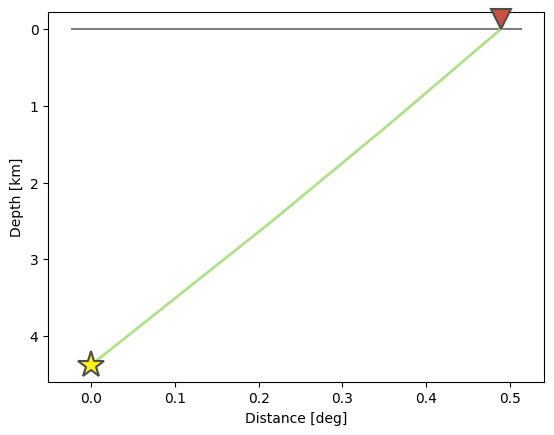

In [7]:
# @title
# Diesen Code solltest Du nicht verändern:

arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=[phase_arrivals[0].name])
if eq_type == "local" or eq_type == "hyperlocal":
  ax = arrivals.plot_rays(plot_type="cartesian")
else:
  ax = arrivals.plot_rays()

if eq_type=="global":
  print("Neben den direkten P- und S-Wellen gibt es noch viele weitere Erdbebenwellen-Phasen, die durch Refraktion und Reflektion von P- und S-Wellen enstehen.")
  print("Sie breiten sich durch andere Erdschichten aus und erreichen den RasberryShake zu anderen Zeiten.")
  arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=["ttbasic"])
  ax = arrivals.plot_rays()
  print(arrivals)
  print("")
  print("Durch das Picken verschiedener Phasen für viele Erdbeben können Seismologen und Seismologinnen die Geschwindigkeiten verschiedener Gesteinsschichten und den Aufbau der Erde bestimmen.")
